<a href="https://colab.research.google.com/github/Shruti-Raj-Vansh-Singh/Image-segmentation-on-CAMVID/blob/main/Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segementation
Classifiying each pixel in the image to a particular class.

In [3]:
!pip install fastai==2.3.0

     |████████████████████████████████| 194kB 7.3MB/s 
     |████████████████████████████████| 776.8MB 25kB/s 
     |████████████████████████████████| 12.8MB 259kB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [3]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.data.all import *
from PIL import Image

import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
fastai.__version__

'2.3.0'

### Dataset

In [5]:
dataset_path = untar_data(URLs.CAMVID)
dataset_path.ls()

(#4) [Path('/root/.fastai/data/camvid/codes.txt'),Path('/root/.fastai/data/camvid/labels'),Path('/root/.fastai/data/camvid/images'),Path('/root/.fastai/data/camvid/valid.txt')]

In [6]:
path_labels = dataset_path/'labels'
path_image = dataset_path/'images'

In [7]:
fnames = get_image_files(path_image)
fnames[:3]

(#3) [Path('/root/.fastai/data/camvid/images/0016E5_08021.png'),Path('/root/.fastai/data/camvid/images/0001TP_009840.png'),Path('/root/.fastai/data/camvid/images/Seq05VD_f04080.png')]

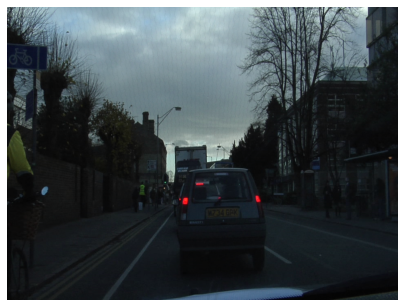

In [8]:
#let us open an image
image_file = fnames[10]
img = PILImage.create(image_file)
img.show(figsize=(7,7))

In [9]:
lnames = get_image_files(path_labels)
lnames[:3]

(#3) [Path('/root/.fastai/data/camvid/labels/0016E5_04560_P.png'),Path('/root/.fastai/data/camvid/labels/Seq05VD_f03120_P.png'),Path('/root/.fastai/data/camvid/labels/0006R0_f01830_P.png')]

In [10]:
#get the labels of the dataset
get_mask = lambda x : path_labels/f'{x.stem}_P{x.suffix}'

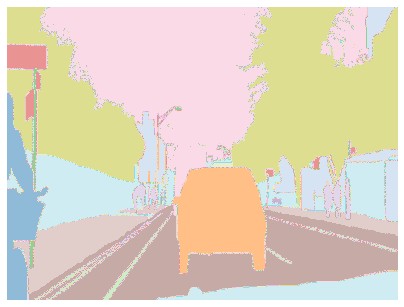

In [11]:
mask = PILMask.create(get_mask(image_file))
mask.show(figsize=(7,7))

In [12]:
tensor(mask)

tensor([[26, 26, 26,  ..., 30, 30, 30],
        [26, 26, 26,  ..., 26, 30, 30],
        [26, 26, 26,  ..., 26, 26, 30],
        ...,
        [ 2,  2,  2,  ..., 30, 30, 30],
        [ 2,  2,  2,  ..., 30, 30, 30],
        [ 2,  2,  2,  ..., 30, 30, 30]], dtype=torch.uint8)

In [13]:
#loading the codes
codes = np.loadtxt(dataset_path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [14]:
codes.shape

(32,)

In [15]:
#for the first go let us take half the size of the images
size = mask.shape
size

(720, 960)

In [16]:
#since size is a tuple, we cannot directly use size//2 for reducing the size of the image to half
new_size = tuple(int(x/2) for x in size)
new_size

(360, 480)

In [17]:
datablock = DataBlock(
    blocks = (ImageBlock, MaskBlock(codes)),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.1),
    get_y = get_mask,
    batch_tfms = [*aug_transforms(size=new_size), Normalize.from_stats(*imagenet_stats)]
)

In [18]:
dls = datablock.dataloaders(path_image, bs=8)

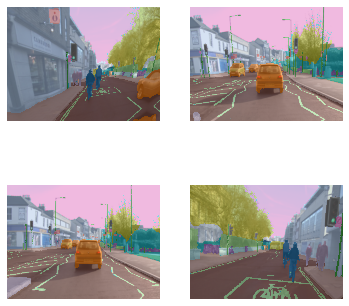

In [19]:
dls.show_batch(max_n=4)

In [20]:
dls.vocab=codes

In [21]:
#let's code the oputput value to a number
name2id = {v:k for k,v in enumerate(codes)}
name2id

{'Animal': 0,
 'Archway': 1,
 'Bicyclist': 2,
 'Bridge': 3,
 'Building': 4,
 'Car': 5,
 'CartLuggagePram': 6,
 'Child': 7,
 'Column_Pole': 8,
 'Fence': 9,
 'LaneMkgsDriv': 10,
 'LaneMkgsNonDriv': 11,
 'Misc_Text': 12,
 'MotorcycleScooter': 13,
 'OtherMoving': 14,
 'ParkingBlock': 15,
 'Pedestrian': 16,
 'Road': 17,
 'RoadShoulder': 18,
 'SUVPickupTruck': 22,
 'Sidewalk': 19,
 'SignSymbol': 20,
 'Sky': 21,
 'TrafficCone': 23,
 'TrafficLight': 24,
 'Train': 25,
 'Tree': 26,
 'Truck_Bus': 27,
 'Tunnel': 28,
 'VegetationMisc': 29,
 'Void': 30,
 'Wall': 31}

In this dataset, there are some pixels that do not have a label associated with them and we need to remove those pixels from our accuracy. So we make our own accuracy function

In [22]:
void_codes = name2id['Void']

In [23]:
def acc_camvid(output,target):
  target = target.sqeeze(1)     #removes 1 dimension from the matrix
  mask = (target!=void_code)
  return (output.argmax(dim=1)[mask]==target[mask]).float().mean()

In [24]:
opt = ranger

In [25]:
learn = unet_learner(dls, resnet34, opt_func=opt, self_attention=True, act_cls=Mish)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [26]:
learn.summary()

DynamicUnet (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 180 x 240  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.0012022644514217973)

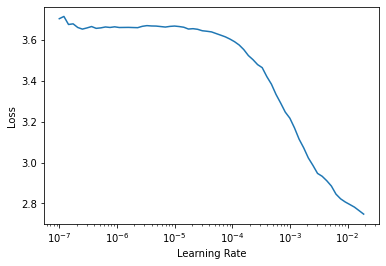

In [27]:
learn.lr_find()

In [28]:
lr = 1e-3

In [29]:
#with a new optimizer the function to fit our model will also be different
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,time
0,1.122042,0.683178,01:53
1,0.689741,0.479793,01:51
2,0.533398,0.412717,01:51
3,0.442486,0.361254,01:51
4,0.398243,0.332093,01:51
5,0.367383,0.312662,01:51
6,0.336775,0.297771,01:51
7,0.317949,0.284447,01:51
8,0.288590,0.269378,01:51
9,0.254065,0.257128,01:51


In [30]:
learn.save('stage-1')
learn.load('stage-1')

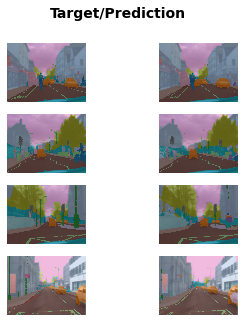

In [31]:
learn.show_results(max_n=4, figsize=(5,5))

Unfreez our model and reduce the learning rate

In [32]:
lrs = slice(lr/400, lr/4)

In [33]:
lr, lrs

(0.001, slice(2.5e-06, 0.00025, None))

In [34]:
learn.unfreeze()

In [35]:
learn.fit_flat_cos(12,lrs)

epoch,train_loss,valid_loss,time
0,0.238778,0.254927,01:57
1,0.231842,0.246503,01:56
2,0.225210,0.245895,01:56
3,0.222385,0.239666,01:56
4,0.211239,0.240236,01:56
5,0.208404,0.235138,01:56
6,0.202366,0.232903,01:56
7,0.199078,0.230437,01:56
8,0.195439,0.233416,01:56
9,0.188419,0.226296,01:56


In [36]:
learn.save('model-1')

Path('models/model-1.pth')

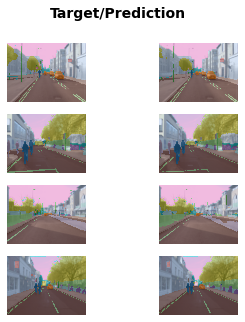

In [37]:
learn.show_results(max_n=4, figsize=(5,5))

## Inference

WE have taken 5 images for our testing set


In [38]:
dl = learn.dls.test_dl(fnames[:5])

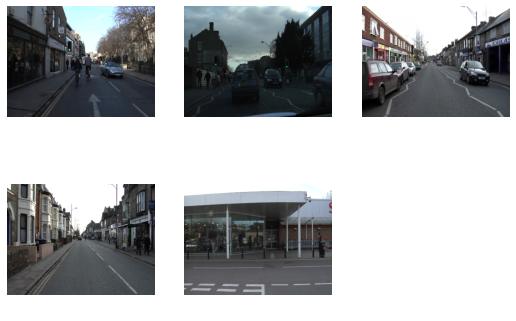

In [39]:
dl.show_batch()

In [40]:
predictions = learn.get_preds(dl=dl)

In [41]:
predictions[0].shape

torch.Size([5, 32, 360, 480])

In [45]:
#looking at the forst picture
pred1 = predictions[0][0]
pred1.shape

torch.Size([32, 360, 480])

In [46]:
pred_arx = pred1.argmax(dim=0)

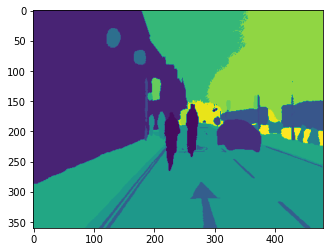

In [48]:
plt.imshow(pred_arx)


We can save the raw image as it is in the following way

In [52]:
torch.save(predictions[0][0], 'Image1.pt')


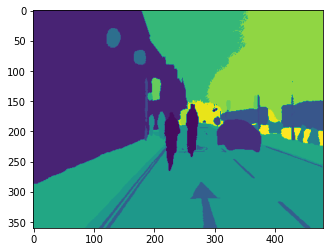

In [55]:
pred1 = torch.load('Image1.pt')
plt.imshow(pred1.argmax(dim=0))

We can also store these images as a numpy array to images

In [56]:
for i, pred in enumerate(predictions[0]):
  pred_arg = pred.argmax(dim=0).numpy()
  rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
  im = Image.fromarray(rescaled)
  im.save(f'Image_{i}.png')

